## [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras

The goal of this assignment is to develop and test two text classification systems:

- **Task 1:** sentiment analysis, in particular, to predict the sentiment of movie reviews, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).

For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**).
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1.
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2.
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such as laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)

### Data - Task 1

The data you will use for Task 1 is taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given functions. You can also write any auxiliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy, and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, etc.

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself.

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fixing random seed for reproducibility
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
sentiment_dev = pd.read_csv('data_sentiment/dev.csv', names=['text', 'label'])
sentiment_test = pd.read_csv('data_sentiment/test.csv', names=['text', 'label'])
sentiment_train = pd.read_csv('data_sentiment/train.csv', names=['text', 'label'])

If you use Pandas you can see a sample of the data.

In [3]:
sentiment_train.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:

In [4]:
sentiment_dev_texts = list(sentiment_dev['text'])
sentiment_dev_labels = np.array(sentiment_dev['label'])

sentiment_test_texts = list(sentiment_test['text'])
sentiment_test_labels = np.array(sentiment_test['label'])

sentiment_train_texts = list(sentiment_train['text'])
sentiment_train_labels = np.array(sentiment_train['label'])

# Bag-of-Words Representation

To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).

## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should:
- tokenise all texts into a list of unigrams (tip: using a regular expression)
- remove stop words (using the one provided or one of your preference)
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).

In [5]:
default_stop_words = {
    'a', 'ad', 'after', 'again', 'all', 'also', 'am', 'an', 'and', 'any',
    'are', 'as', 'at', 'be', 'because', 'been', 'being', 'between', 'both',
    'but', 'by', 'can', 'could', 'does', 'each', 'ed', 'eg', 'either', 'etc',
    'even', 'ever', 'every', 'for', 'from', 'had', 'has', 'have', 'he', 'her',
    'hers', 'herself', 'him', 'himself', 'his', 'i', 'ie', 'if', 'in', 'inc',
    'into', 'is', 'it', 'its', 'itself', 'li', 'll', 'ltd', 'may', 'maybe',
    'me', 'might', 'mine', 'minute', 'minutes', 'must', 'my', 'myself',
    'neither', 'nor', 'now', 'of', 'on', 'only', 'or', 'other', 'our', 'ours',
    'ourselves', 'own', 'same', 'seem', 'seemed', 'shall', 'she', 'some',
    'somehow', 'something', 'sometimes', 'somewhat', 'somewhere', 'spoiler',
    'spoilers', 'such', 'suppose', 'that', 'the', 'their', 'theirs', 'them',
    'themselves', 'there', 'these', 'they', 'this', 'those', 'thus', 'to',
    'today', 'tomorrow', 'us', 've', 'vs', 'was', 'we', 'were', 'what',
    'whatever', 'when', 'where', 'which', 'who', 'whom', 'whose', 'will',
    'with', 'yesterday', 'you', 'your', 'yours', 'yourself', 'yourselves'
}

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw,
                   ngram_range=(1, 3),
                   token_pattern=r'\b[A-Za-z]{2,}\b',
                   stop_words=default_stop_words,
                   vocab=None):

    tokens = [
        word.lower() for word in re.findall(token_pattern, x_raw)
        if word.lower() not in stop_words
    ]

    ngrams = []

    for n in range(ngram_range[0], ngram_range[1] + 1):
        if n == 1:
            # Create unigram by concatenating list
            ngrams += tokens
        else:
            # Create bigram / trigram by unzipping list
            ngrams += zip(*(tokens[i:] for i in range(n)))

    return [ngram for ngram in ngrams if ngram in vocab] if vocab else ngrams

In [7]:
extract_ngrams('this is a great movie to watch')

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [8]:
extract_ngrams('this is a great movie to watch',
               ngram_range=(1, 2),
               vocab={'great', ('great', 'movie')})

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [9]:
def get_vocab(X_raw,
              ngram_range=(1, 3),
              token_pattern=r'\b[A-Za-z]{2,}\b',
              min_df=1,
              keep_topN=None,
              stop_words=default_stop_words):

    df = Counter()
    ngram_counts = Counter()

    for text in X_raw:
        # A list of ngrams for the given document `text`
        ngram_list = extract_ngrams(text, ngram_range, token_pattern, stop_words)
        
        # Count document frequency
        df.update(set(ngram_list))

        # Count ngram frequency
        ngram_counts.update(ngram for ngram in ngram_list if df[ngram] >= min_df)
    
    # Extract ngram into vocab set
    vocab = {ngram for ngram, _ in ngram_counts.most_common(keep_topN)}

    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
vocab, df, _ = get_vocab(sentiment_train_texts, keep_topN=5000)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['intriguing', 'takes', 'joy', 'approach', ('love', 'interest'), 'master', 'marshall', 'annoying', 'crashes', 'wall', 'cindy', 'fails', 'intelligent', 'outcome', ('thought', 'provoking'), 'ross', 'unfortunately', ('up', 'one'), 'malcolm', 'smile', 'mistake', 'use', 'son', 'turn', 'rock', 'kennedy', 'braveheart', 'legend', 'wear', 'fix', 'ms', 'status', 'members', 'residents', 'led', 'added', 'kid', 'trash', 'carry', ('doesn', 'make'), 'wood', 'subplot', 'combat', 'appeal', 'before', ('like', 'most'), 'portrayed', 'upset', 'switch', ('real', 'life'), 'kill', ('geoffrey', 'rush'), 'park', 'effort', 'pacing', ('ghost', 'dog'), ('american', 'pie'), 'betty', ('steve', 'buscemi'), 'natasha', 'battles', ('no', 'one'), 'fish', ('tv', 'show'), ('film', 'however'), 'enter', 'decade', 'opinion', 'everett', 'unusual', 'independence', 'aspect', 'starts', ('would', 'make'), 'places', 'eager', 'under', 'tarzan', 'disguise', 'ruthless', 'covering', 'realize', 'affection', 'jerry', ('about', 'how

Then, you need to create vocabulary id -> word and word -> id dictionaries for reference:

In [11]:
vocab_id_to_word = dict(enumerate(vocab))

word_to_vocab_id = {v: k for k, v in vocab_id_to_word.items()}

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [12]:
sentiment_train_texts_ngrams = (extract_ngrams(text, vocab=vocab)
                                for text in sentiment_train_texts)

sentiment_dev_texts_ngrams = (extract_ngrams(text, vocab=vocab)
                              for text in sentiment_dev_texts)

sentiment_test_texts_ngrams = (extract_ngrams(text, vocab=vocab)
                               for text in sentiment_test_texts)

## Vectorise documents

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.

In [13]:
def vectorise(X_ngram, vocab):
    X_vec = []

    for ngram_list in X_ngram:
        counter = Counter(ngram_list)
        X_vec.append([counter[v] for v in vocab])

    return np.array(X_vec)

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

### Count vectors

In [14]:
sentiment_train_count = vectorise(sentiment_train_texts_ngrams, vocab)

sentiment_dev_count = vectorise(sentiment_dev_texts_ngrams, vocab)

sentiment_test_count = vectorise(sentiment_test_texts_ngrams, vocab)

In [15]:
sentiment_train_count.shape

(1400, 5000)

In [16]:
sentiment_train_count[:2,:50]

array([[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 2, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1]])

### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [17]:
total_sentiment_train_docs = len(sentiment_train_texts)
total_sentiment_dev_docs = len(sentiment_dev_texts)
total_sentiment_test_docs = len(sentiment_test_texts)

_, sentiment_dev_df, _ = get_vocab(sentiment_dev_texts, keep_topN=5000)

_, sentiment_test_df, _ = get_vocab(sentiment_test_texts, keep_topN=5000)

sentiment_train_idf = np.array([
    np.log10(total_sentiment_train_docs / df[v]) for v in vocab]
)

sentiment_dev_idf = np.array([
    np.log10(total_sentiment_dev_docs / sentiment_dev_df[v])
    if sentiment_dev_df[v] else 0 for v in vocab
])

sentiment_test_idf = np.array([
    np.log10(total_sentiment_test_docs / sentiment_test_df[v])
    if sentiment_test_df[v] else 0 for v in vocab
])

Then transform your count vectors to TF.IDF vectors:

In [18]:
# Use the "log normalisation" variant to scale TF for better results
sentiment_train_tfidf = np.log10(1 + sentiment_train_count) * sentiment_train_idf

sentiment_dev_tfidf = np.log10(1 + sentiment_dev_count) * sentiment_dev_idf

sentiment_test_tfidf = np.log10(1 + sentiment_test_count) * sentiment_test_idf

In [19]:
sentiment_train_tfidf[1, :50]

array([0.        , 0.17014307, 0.        , 0.58796329, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.38979462])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers

and returns:

- `sig`: the sigmoid of `z`

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [21]:
print(sigmoid(0))
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [22]:
def predict_proba(X, weights):
    z = X.dot(weights)

    return sigmoid(z)

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [23]:
def predict_class(X, weights):
    return [0 if prob < 0.5 else 1 for prob in predict_proba(X, weights)]

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [24]:
def binary_loss(X, Y, weights, alpha=0.00001):
    predicted_probabilities = predict_proba(X, weights)

    l = -Y * np.log(predicted_probabilities) - (1 - Y) * np.log(1 - predicted_probabilities)

    # L2 Regularisation
    l += alpha * weights.dot(weights)

    # Return the average loss
    return np.mean(l)

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)

and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [25]:
def SGD(X_tr, Y_tr, X_dev, Y_dev, lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    # fixing random seed for reproducibility
    np.random.seed(123)
    training_loss_history = []
    validation_loss_history = []
    
    # Initialise weight to zero
    weights = np.zeros(X_tr.shape[1])

    # Create training tuples
    train_docs = list(zip(X_tr, Y_tr))

    for epoch in range(epochs):
        # Randomise order in train_docs
        np.random.shuffle(train_docs)

        for x_i, y_i in train_docs:
            weights -= lr * (x_i * (predict_proba(x_i, weights) - y_i) + 2 * alpha * weights)

        # Monitor training and validation loss
        cur_loss_tr = binary_loss(X_tr, Y_tr, weights, alpha)
        cur_loss_dev = binary_loss(X_dev, Y_dev, weights, alpha)

        # Early stopping
        if epoch > 0 and validation_loss_history[-1] - cur_loss_dev < tolerance:
            break
        else:
            training_loss_history.append(cur_loss_tr)
            validation_loss_history.append(cur_loss_dev)

        if print_progress:
            print(f'Epoch: {epoch} | Training loss: {cur_loss_tr} | Validation loss: {cur_loss_dev}')
            
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Binary Logistic Regression with Count Vectors

First train the model using SGD:

In [26]:
w_count, tr_loss_count, dev_loss_count = SGD(X_tr=sentiment_train_count,
                                             Y_tr=sentiment_train_labels,
                                             X_dev=sentiment_dev_count,
                                             Y_dev=sentiment_dev_labels,
                                             lr=0.00010125,
                                             alpha=0.00001,
                                             epochs=100)

Epoch: 0 | Training loss: 0.6348491121448473 | Validation loss: 0.6487531390444826
Epoch: 1 | Training loss: 0.5938450068965224 | Validation loss: 0.6197582795219723
Epoch: 2 | Training loss: 0.5620854544884649 | Validation loss: 0.5968170578825471
Epoch: 3 | Training loss: 0.5361249484005611 | Validation loss: 0.5793664064778387
Epoch: 4 | Training loss: 0.5135391035412232 | Validation loss: 0.5651486900885704
Epoch: 5 | Training loss: 0.4944097063594531 | Validation loss: 0.5530542328543285
Epoch: 6 | Training loss: 0.47777782565211835 | Validation loss: 0.5421463814864184
Epoch: 7 | Training loss: 0.4629537317844918 | Validation loss: 0.5337658704752338
Epoch: 8 | Training loss: 0.44909198060596117 | Validation loss: 0.524853646854113
Epoch: 9 | Training loss: 0.43698328849816304 | Validation loss: 0.5178529834051904
Epoch: 10 | Training loss: 0.4268767904066057 | Validation loss: 0.5126123829317655
Epoch: 11 | Training loss: 0.415327339357736 | Validation loss: 0.5051367678530422
E

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

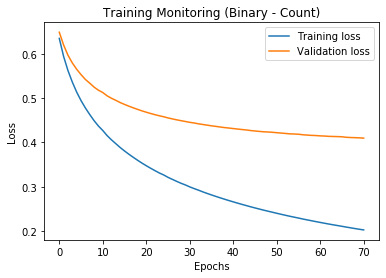

In [27]:
plt.plot(tr_loss_count, label='Training loss')
plt.plot(dev_loss_count, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training Monitoring (Binary - Count)')

plt.legend()

plt.show()

According to the plot **Training Monitoring (Binary - Count)**, 

1. The training loss decreases as epoch increases and eventually reaches a point of stability
2. The validation loss decreases as epoch increases and eventually reaches a point of stability
3. There exists a "generalisation gap" between validation and training loss

The following techniques are implemented in the Stochastic Gradient Descent algorithm to avoid overfitting of the training data:

1. Early stopping
2. L2 regularisation

Hence, the model is **about right**.

Compute accuracy, precision, recall and F1-scores:

In [28]:
args = sentiment_test_labels, predict_class(sentiment_test_count, w_count)

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args))
print('Recall:', recall_score(*args))
print('F1-Score:', f1_score(*args))

Accuracy: 0.8625
Precision: 0.8536585365853658
Recall: 0.875
F1-Score: 0.8641975308641976


Finally, print the top-10 words for the negative and positive class respectively.

In [29]:
top10_positive_ids = (-w_count).argsort()[:10]
top10_negative_ids = w_count.argsort()[:10]

print(
    f'Top 10 positive: {[vocab_id_to_word[id] for id in top10_positive_ids]} \n'
)
print(
    f'Top 10 negative: {[vocab_id_to_word[id] for id in top10_negative_ids]}'
)

Top 10 positive: ['great', 'well', 'seen', 'fun', 'life', 'movies', 'world', 'many', 'quite', 'see'] 

Top 10 negative: ['bad', 'worst', 'unfortunately', 'why', 'nothing', 'script', 'boring', 'plot', 'supposed', 'looks']


### Features Evaluation

The top 10 features obtained for each class using **count vectors** are reasonable.

## Train and Evaluate Binary Logistic Regression with TF.IDF Vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).

In [30]:
w_tfidf, tr_loss_tfidf, dev_loss_tfidf = SGD(X_tr=sentiment_train_tfidf,
                                             Y_tr=sentiment_train_labels,
                                             X_dev=sentiment_dev_tfidf,
                                             Y_dev=sentiment_dev_labels,
                                             lr=0.00322,
                                             alpha=0.0005,
                                             epochs=100)

Epoch: 0 | Training loss: 0.6125588594833006 | Validation loss: 0.647706528804582
Epoch: 1 | Training loss: 0.5530253406900361 | Validation loss: 0.6150800703145565
Epoch: 2 | Training loss: 0.5069409022845992 | Validation loss: 0.5894863184098205
Epoch: 3 | Training loss: 0.47004008441871326 | Validation loss: 0.5694136509002529
Epoch: 4 | Training loss: 0.43976084989704306 | Validation loss: 0.5532699411696317
Epoch: 5 | Training loss: 0.41423882254708605 | Validation loss: 0.5393659995798531
Epoch: 6 | Training loss: 0.392541298038376 | Validation loss: 0.5278636068389434
Epoch: 7 | Training loss: 0.37375383411174645 | Validation loss: 0.518163125236696
Epoch: 8 | Training loss: 0.3572679116483345 | Validation loss: 0.5096129103639213
Epoch: 9 | Training loss: 0.3427279503022216 | Validation loss: 0.5021873336065107
Epoch: 10 | Training loss: 0.3298796818923012 | Validation loss: 0.4957784337614395
Epoch: 11 | Training loss: 0.3181586722159671 | Validation loss: 0.4898697002075382
E

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

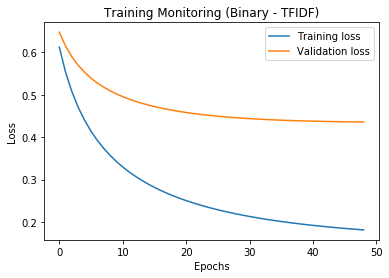

In [31]:
plt.plot(tr_loss_tfidf, label='Training loss')
plt.plot(dev_loss_tfidf, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training Monitoring (Binary - TFIDF)')

plt.legend()

plt.show()

According to the plot **Training Monitoring (Binary - TFIDF)**, 

1. The training loss decreases as epoch increases and eventually reaches a point of stability
2. The validation loss decreases as epoch increases and eventually reaches a point of stability
3. There exists a "generalisation gap" between validation and training loss

The following techniques are implemented in the Stochastic Gradient Descent algorithm to avoid overfitting of the training data:

1. Early stopping
2. L2 regularisation

Hence, the model is **about right**.

Compute accuracy, precision, recall and F1-scores:

In [32]:
args = sentiment_test_labels, predict_class(sentiment_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args))
print('Recall:', recall_score(*args))
print('F1-Score:', f1_score(*args))

Accuracy: 0.8925
Precision: 0.9025641025641026
Recall: 0.88
F1-Score: 0.8911392405063291


Print top-10 most positive and negative words:

In [33]:
top10_positive_ids = (-w_tfidf).argsort()[:10]
top10_negative_ids = w_tfidf.argsort()[:10]

print(
    f'Top 10 positive: {[vocab_id_to_word[id] for id in top10_positive_ids]} \n'
)
print(
    f'Top 10 negative: {[vocab_id_to_word[id] for id in top10_negative_ids]}'
)

Top 10 positive: ['hilarious', 'perfectly', 'terrific', 'great', 'memorable', 'overall', 'definitely', 'perfect', 'excellent', 'fun'] 

Top 10 negative: ['bad', 'worst', 'boring', 'supposed', 'unfortunately', 'ridiculous', 'waste', 'awful', 'script', 'nothing']


### Features Evaluation

The top 10 features obtained for each class using **TF.IDF vectors** are reasonable. They are more relevant than the features obtained using **count vectors**.

## If we were to apply the classifier we've learned into a different domain such as laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

### Count Vectors

The following top 10 words: 'great', 'well', 'bad', 'worst', 'unfortunately' are common words in reviews. If the classifier is to apply into a different domain, it is expected that the classier will be able to correctly classify some of the reviews, assuming that the reviews satisfy the following conditions:

1. The positive reviews must contain words that have been learnt by the model as positive (e.g. great, well, etc.)
2. The negative reviews must contain words that have been learnt by the model as negative (e.g. bad, worst, etc.)

However, this assumption is unlikely to be true for most of the laptop or restaurant reviews in real-life scenarios. A user may give a positive rating despite writing many negative words in the review. It is also possible that a review contains only neutral unemotional words but expresses a different sentiment.

Most of the top features are irrelevant to laptop or restaurant reviews, such as 'fun', 'movies', 'script', 'boring, 'plot', etc. This implies that the classifier is likely to be underfitting in the new domains and perform worse than the movie domain. Therefore, these features **would not generalise well** in a new domain.

### TF.IDF Vectors

The TF.IDF vectors model has better performance than the count vectors model on the movie review domain due to the top features being identified more accurately. Conversely, this has implied that the TF.IDF vectors model is less generalised than the count vectors model. Hence, the features **would not generalise well** in a new domain too.

### Features in the New Domain

Apart from the common sentiment lexicon (e.g. good, bad), the classifier could pick up features that is specific to the new domain. Below is an estimation of possible top features in the respective new domains:

Laptop reviews: The features learned are likely to be the terms that are related to the attribute of an electrical device, as shown in the following list. Possible n-grams may include `(durable, battery)`, `(hd, screen)`, etc.

- long ; short (battery life)
- light ; heavy (weight)
- thin ; bulky (physical size)
- cheap ; expensive (price)
- fast ; slow (performance

Restaurant reviews: The features learned are likely to be the terms that are related to food quality and the customer experience in the restaurant, as shown in the following list. Possible n-grams may include `(polite, staff)`, `(tasty, food)`, etc.

- long ; short (waiting time)
- delicious ; disgusting, tasteless (food quality) 
- polite ; rude (staff attitude)
- cosy ; dull (environment)
- clean ; dirty, messy (hygiene)
- cheap ; expensive (price)

## Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How does the regularisation strength affect performance?

### Objective

The primary objective is to find the best configuration of hyperparameters that will give the best scores on the development and test set. It can be achieved by improving the generalisation of the learned model through the following processes:

1. Lower the generalisation gap between validation and training loss. This is based on the assumption that both the validation and training loss has reached a point of stability, and the model is in good fit.

2. Improve, or at least maintain the precision, recall, and F1-score while lowering the validation loss.

The processes are carried out using *trial and error* strategy. Small performance improvements (≤ 2%) are expected after the optimisation. The quality of the training dataset is still the major factor in model performance.

While many existing hyperparameters optimisation algorithms are better than the chosen strategy, almost all of them require a searching algorithm to work. After considering the scope of this assignment and the feasibility of self-implementing a searching algorithm, it is decided to choose a simpler approach for experimentation and learning purpose.

### Limitations of Trial and Error Method

Although the trial and error method is a straightforward strategy and requires no extra implementation, it is prone to the local optimum problem. It is impractical to try every possible combination of learning rate and regularisation strength to find the optimal result. Therefore, the best achievable performance improvement through fine-tuning is largely dependent on the initial set of values selected to explore the hyperparameters. 

Furthermore, another optimisation problem has arisen as the number of hyperparameters to search is more than one. This has lead to another assumption that the optimisation order of hyperparameters may have a certain impact on the final result.

### Hyperparameters Optimisation

Before performing the search on hyperparameters, the lower and upper bounds for the values of the hyperparameters need to be defined. The lower bound value is the baseline for the model performance, and the upper bound is the value where the performance would start dropping. Both lower bound and upper bound would converge after each trial. 

For consistency, the initial lower and upper bound of learning rate is set to `0.0001` and `0.1` respectively. The initial lower and upper bound of regularisation strength is set to `0.00001` and `0.01` respectively.

#### Optimisation procedure for learning rate

1. Set `lr=0.0001` and `alpha=0.00001`. Train and record the lower bound scores.

2. If the gradient descent is taking too many epochs (> 100) to converge, increase the value of `lr`. Repeat this step until the number of epochs is below 100. If the final scores are higher than the current lower bound scores, then update the lower bound, else update the upper bound

3. If the current `lr` is the lower bound value, increase `lr` until the new scores are lower than the current lower bound scores, then record this value as the new upper bound.

4. If the current `lr` is the upper bound value, decrease `lr` until the new scores are higher than the current upper bound scores. Record this value as the new lower bound.

5. Repeat Step 3 and 4 until the upper bound scores ≥ lower bound scores. The `lr` value is now considered to be the optimal value.


#### Optimisation procedure for regularisation strength

1. Set `lr` to the optimal value obtained and `alpha=0.00001`. Train and record the lower bound validation loss.

2. If the current `alpha` is the lower bound value, increase `alpha` until the validation loss has increased **OR** the scores have decreased. Record this value as the new upper bound

3. If the current `alpha` is the upper bound value, decrease `alpha` until the new validation loss is lower than the current upper bound validation loss. Record this value as the new lower bound.

4. Repeat Step 2 and 3 until a lower validation loss has been found **OR** the scores have improved.

**Note:** The optimisation procedure is a general guideline for the manual hyperparameters search. There may be cases where several changes have to be adapted. 

1. There is no fixed value of how much should `lr` and `alpha` increase or decrease during the optimisation. `lr` and `alpha` are adjusted according to the amount of changes in scores and validation loss in the previous trial.

2. When optimising `alpha`, it is possible that the validation loss and scores are not improving after several trials. In this case, the initial `alpha` value is considered to be the optimum.


### Count Vectors

#### Optimising Learning Rate

Initial parameters: `lr=0.0001, alpha=0.00001`

| Trial | Learning rate | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.0001        | 70     | 0.2037   | 0.4100    | 0.8536    | 0.875  | 0.8641   |
| 1     | 0.00011       | 70     | 0.1932   | 0.4072    | 0.8522    | 0.865  | 0.8585   |
| 2     | 0.000105      | 70     | 0.1983   | 0.4085    | 0.8487    | 0.87   | 0.8592   |
| 3     | 0.0001025     | 70     | 0.2009   | 0.4092    | 0.8487    | 0.87   | 0.8592   |
| 4     | 0.00010125    | 70     | 0.2023   | 0.4096    | 0.8536    | 0.875  | 0.8641   |

The optimal `lr` is found to be `0.00010125`.

#### Optimising Regularisation Strength

Initial parameters: `lr=0.00010125, alpha=0.00001`

| Trial | Alpha      | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|------------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.00001    | 70     | 0.2023   | 0.40962   | 0.8536    | 0.875  | 0.8641   |
| 1     | 0.00002    | 70     | 0.2024   | 0.40966   | 0.8536    | 0.875  | 0.8641   |
| 2     | 0.000015   | 70     | 0.2023   | 0.40964   | 0.8536    | 0.875  | 0.8641   |
| 3     | 0.0000125  | 70     | 0.2023   | 0.40963   | 0.8536    | 0.875  | 0.8641   |
| 4     | 0.00001125 | 70     | 0.2023   | 0.40963   | 0.8536    | 0.875  | 0.8641   |
| 5     | 0.0001     | 70     | 0.2028   | 0.4099    | 0.8536    | 0.875  | 0.8641   |
| 6     | 0.001      | 70     | 0.2074   | 0.4134    | 0.8536    | 0.875  | 0.8641   |
| 7     | 0.01       | 47     | 0.2788   | 0.4487    | 0.8514    | 0.86   | 0.8557   |

No better `alpha` has been found. The initial `alpha` is considered to be the optimal value.

**Conclusion**: Based on the trials above, it can be concluded that the optimal values are `lr=0.00010125` and `alpha=0.00001`


### TF.IDF Vectors

#### Optimising Learning Rate

Initial parameters: `lr=0.0001, alpha=0.00001`

| Trial | Learning rate | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.0001        | 99     | 0.5025   | 0.5866    | 0.8436    | 0.89   | 0.8661   |
| 1     | 0.0002        | 99     | 0.4053   | 0.5329    | 0.8634    | 0.885  | 0.8740   |
| 2     | 0.0003        | 99     | 0.3439   | 0.4994    | 0.8676    | 0.885  | 0.8762   |
| 3     | 0.001         | 99     | 0.1760   | 0.4125    | 0.8923    | 0.87   | 0.8810   |
| 4     | 0.002         | 99     | 0.1059   | 0.3819    | 0.8883    | 0.875  | 0.8816   |
| 5     | 0.003         | 99     | 0.0762   | 0.3724    | 0.8826    | 0.865  | 0.8737   |
| 6     | 0.0029        | 99     | 0.0784   | 0.3730    | 0.8826    | 0.865  | 0.8737   |
| 7     | 0.0028        | 99     | 0.0807   | 0.3736    | 0.8871    | 0.865  | 0.8759   |
| 8     | 0.0027        | 99     | 0.0831   | 0.3743    | 0.8871    | 0.865  | 0.8759   |
| 9     | 0.0026        | 99     | 0.0858   | 0.3751    | 0.8871    | 0.865  | 0.8759   |
| 10    | 0.0025        | 99     | 0.0893   | 0.3762    | 0.8883    | 0.875  | 0.8816   |

The "temporary" optimal `lr` is found to be `0.0025` because the model is not showing a converging trenddespite the learning rate has increased significantly.

#### Optimising Regularisation Strength

Initial parameters: `lr=0.0025, alpha=0.00001`

| Trial | Alpha   | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.00001 | 99     | 0.0893   | 0.3762    | 0.8883    | 0.875  | 0.8816   |
| 1     | 0.00002 | 99     | 0.0904   | 0.3775    | 0.8883    | 0.875  | 0.8816   |
| 2     | 0.00004 | 99     | 0.0940   | 0.3805    | 0.8838    | 0.875  | 0.8793   |
| 3     | 0.0001  | 99     | 0.1044   | 0.3893    | 0.8838    | 0.875  | 0.8793   |
| 4     | 0.0002  | 83     | 0.1302   | 0.4043    | 0.8883    | 0.875  | 0.8816   |
| 5     | 0.0004  | 70     | 0.1645   | 0.4265    | 0.8934    | 0.88   | 0.8866   |
| 6     | 0.0006  | 58     | 0.1943   | 0.4439    | 0.9025    | 0.88   | 0.8911   |
| 7     | 0.0008  | 48     | 0.2206   | 0.4583    | 0.8974    | 0.875  | 0.8860   |

A converging pattern has been observed. However, since the `lr` used is the "temporary" optimal value, a further optimisation is required validate it.

#### Optimising Learning Rate and Regularisation Strength

Based on the trials above, it could be concluded that the optimal values are `lr=0.0025` and `alpha=0.0006`. However, it has been observed that increasing the learning rate only is not decreasing the epochs required. The epochs required only start decreasing when `alpha` is increased to `0.0002`. Therefore, further optimisation is required to validate the optimal values.

Initial parameters: `lr=0.0025, alpha=0.0006`

| Trial | Learning rate | Alpha   | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|---------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.0025        | 0.0006  | 58     | 0.1943   | 0.4439    | 0.9025    | 0.88   | 0.8911   |
| 1     | 0.003         | 0.0006  | 47     | 0.1955   | 0.4440    | 0.9025    | 0.88   | 0.8911   |
| 2     | 0.004         | 0.0006  | 37     | 0.1924   | 0.4437    | 0.9025    | 0.88   | 0.8911   |
| 3     | 0.005         | 0.0006  | 29     | 0.1929   | 0.4437    | 0.9025    | 0.88   | 0.8911   |
| 4     | 0.006         | 0.0006  | 24     | 0.1927   | 0.4436    | 0.9025    | 0.88   | 0.8911   |
| 5     | 0.003         | 0.00055 | 51     | 0.1866   | 0.4399    | 0.9025    | 0.88   | 0.8911   |
| 6     | 0.0032        | 0.0005  | 48     | 0.1815   | 0.4359    | 0.9025    | 0.88   | 0.8911   |

After further optimisation, it can be concluded that the optimal values are `lr=0.0032` and `alpha=0.0005`. These two values have the lowest training and validation loss while maintaining the same scores.

### Relationship Between Epochs and Learning Rate

Before conducting any of the optimisation trials, the relationship between epochs and learning can already be deduced from the equation in `SGD` function. By observing the line `weights -= lr * (...)` in `SGD` function, it can be deduced that the larger the learning rate, the bigger the weight update after each epoch. Therefore, it is assumed that the higher the learning rate, the lower the epochs required to converge. 

As shown in the table in section **TF.IDF: Optimising Learning Rate and Regularisation Strength** above, it has been proved that epochs are inversely proportional to the learning rate. Another test has been conducted to further validate the assumption,

- Test vector: `count`
- Parameters: `alpha=0.00001, epochs=300`

| Trial | Learning rate | Epochs required |
|-------|---------------|-----------------|
| 0     | 0.00001       | 299             |
| 1     | 0.0001        | 70              |
| 2     | 0.001         | 14              |
| 3     | 0.01          | 0               |


#### Discussion about Epochs, Learning Rate, and Model Performance

Choosing a good learning rate is challenging as every model differs from each other. Generally, it is required to perform some preliminary analysis on the model performance before the hyperparameters optimisation. 

- If the learning rate is too large, the model may overshoot and lead to divergent behaviour (epochs required is low)
- If the learning rate is too small, the model will require many updates to the weights before the loss is converged (epochs required is high)

### Relationship Between Regularisation Strength and Model Performance

From the table in **Count Vectors: Optimising Regularisation Strength** and **TF.IDF Vectors: Optimising Regularisation Strength**, it is observed that the regularisation strength can affect the epochs required to converge, and thus can affect the model performance indirectly. Moreover, a small change in regularisation strength would only have minimal impact on the overall metrics.

By observing the line `weights -= lr * (... + 2 * alpha * weights)` in `SGD` function, it can be deduced that the higher the regularisation strength, the lower the epochs required to converge. However, as shown in **TF.IDF Vectors: Optimising Regularisation Strength**, increasing the regularisation strength will also increase both training and validation loss. This does not always produce an adverse effect on the model performance, as performance gained has been observed when the regularisation strength has been increased to a certain value.

#### Discussion about Loss and Model Performance

The increase in training and validation loss which lead to the improvement in model performance can be explained as follows:

1. Before the optimisation, the model is slightly overfitted on the training dataset
2. After the optimisation, the increase in regularisation strength has improved the generalisation of the model, thus observing an  increase in training and validation loss

## Full Results

|     LR    |      Precision     | Recall |      F1-Score      |
|:---------:|:------------------:|:------:|:------------------:|
| BOW-count | 0.8536585365853658 |  0.875 | 0.8641975308641976 |
| BOW-tfidf | 0.9025641025641026 |  0.88  | 0.8911392405063291 |

# Multi-class Logistic Regression

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [34]:
topic_dev = pd.read_csv('data_topic/dev.csv', names=['label', 'text'])
topic_test = pd.read_csv('data_topic/test.csv', names=['label', 'text'])
topic_train = pd.read_csv('data_topic/train.csv', names=['label', 'text'])

In [35]:
topic_train.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [36]:
topic_dev_texts = list(topic_dev['text'])
topic_dev_labels = np.array(topic_dev['label'])

topic_test_texts = list(topic_test['text'])
topic_test_labels = np.array(topic_test['label'])

topic_train_texts = list(topic_train['text'])
topic_train_labels = np.array(topic_train['label'])

In [37]:
vocab, df, _ = get_vocab(topic_train_texts, keep_topN=5000)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

[('region', 'south', 'ossetia'), 'delayed', 'takes', 'loans', 'billing', ('chancellor', 'gerhard'), 'joy', ('lower', 'oil', 'prices'), ('al', 'sadr'), 'wall', ('monday', 'saying'), ('strained', 'right'), ('crude', 'prices', 'remain'), 'use', 'son', 'turn', ('four', 'people'), ('search', 'engine'), 'decisive', ('republican', 'national'), ('fell', 'lowest'), ('out', 'olympic', 'tennis'), ('katerina', 'thanou'), 'embassy', 'justin', ('awaited', 'initial'), 'members', ('oil', 'prices', 'upbeat'), ('hours', 'visit'), 'residents', ('maoist', 'rebels'), 'led', 'added', 'kid', 'economic', ('trade', 'deficit'), 'wood', 'appeal', 'before', 'commission', 'upset', 'au', 'kill', ('economic', 'data', 'showing'), 'park', 'effort', 'spokesman', 'battles', ('york', 'stocks'), 'enter', 'decade', ('another', 'record'), ('housing', 'starts', 'rebounded'), 'unusual', 'medtronic', 'independence', 'starts', 'carrier', 'awarded', ('britain', 'charged'), 'under', ('olympic', 'tennis', 'tournament'), ('sa

In [38]:
vocab_id_to_word = dict(enumerate(vocab))

word_to_vocab_id = {v: k for k, v in vocab_id_to_word.items()}

In [39]:
topic_train_texts_ngrams = (extract_ngrams(text, vocab=vocab)
                            for text in topic_train_texts)

topic_dev_texts_ngrams = (extract_ngrams(text, vocab=vocab)
                          for text in topic_dev_texts)

topic_test_texts_ngrams = (extract_ngrams(text, vocab=vocab)
                           for text in topic_test_texts)

### Count vectors

In [40]:
topic_train_count = vectorise(topic_train_texts_ngrams, vocab)

topic_dev_count = vectorise(topic_dev_texts_ngrams, vocab)

topic_test_count = vectorise(topic_test_texts_ngrams, vocab)

### TF.IDF vectors

In [41]:
total_topic_train_docs = len(topic_train_texts)
total_topic_dev_docs = len(topic_dev_texts)
total_topic_test_docs = len(topic_test_texts)

_, topic_dev_df, _ = get_vocab(topic_dev_texts, keep_topN=5000)

_, topic_test_df, _ = get_vocab(topic_test_texts, keep_topN=5000)

topic_train_idf = np.array([
    np.log10(total_topic_train_docs / df[v]) for v in vocab]
)

topic_dev_idf = np.array([
    np.log10(total_topic_dev_docs / topic_dev_df[v])
    if topic_dev_df[v] else 0 for v in vocab
])

topic_test_idf = np.array([
    np.log10(total_topic_test_docs / topic_test_df[v])
    if topic_test_df[v] else 0 for v in vocab
])

# Use the "log normalisation" variant to scale TF for better results
topic_train_tfidf = np.log10(1 + topic_train_count) * topic_train_idf

topic_dev_tfidf = np.log10(1 + topic_dev_count) * topic_dev_idf

topic_test_tfidf = np.log10(1 + topic_test_count) * topic_test_idf

Now you need to change `SGD` to support multiclass datasets. First, you need to develop a `softmax` function. It takes as input:

- `z`: an array of real numbers

and returns:

- `smax`: the softmax of `z`

In [42]:
def softmax(z):
    """
    Compute probability for each class
    """
    e_z = np.exp(z)
    return e_z / np.sum(e_z, axis=1 if e_z.ndim > 1 else None, keepdims=True)

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [43]:
def predict_proba(X, weights):
    """
    :param weights: (3, |vocab|) shape, one weight vector for each class
    """
    z = X.dot(weights.T)
    return softmax(z)

In [44]:
def predict_class(X, weights):
    """
    Each document will have one probability for each class, 
    use argmax to find the highest probability class
    """
    # Add 1 after argmax as the topic class starts from 1
    return np.argmax(predict_proba(X, weights), axis=1) + 1

Test example and expected functionality of the functions above:

In [45]:
X = np.array([[0.1, 0.2], [0.2, 0.1], [0.1, -0.2]])
w = np.array([[2, -5], [-5, 2]])

In [46]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [47]:
predict_class(X, w)

array([2, 1, 1])

Now you need to compute the categorical cross-entropy loss (extending the binary loss to support multiple classes).

In [48]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    # Compute the negative log-likelihood and L2 regularisation for true class only
    l = np.array([
        -np.log(probs[Y[idx] - 1]) + alpha * np.sum(weights[Y[idx] - 1]**2)
        for idx, probs in enumerate(predict_proba(X, weights))
    ])

    # Return average loss
    return np.mean(l)

Finally you need to modify SGD to support the categorical cross entropy loss:

In [49]:
def SGD(X_tr, Y_tr, X_dev, Y_dev, num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    # fixing random seed for reproducibility
    np.random.seed(123)
    training_loss_history = []
    validation_loss_history = []

    # Initialise weight to zero
    weights = np.zeros((num_classes, X_tr.shape[1]))

    # Create training tuples
    train_docs = list(zip(X_tr, Y_tr))

    for epoch in range(epochs):
        # Randomise order in train_docs
        np.random.shuffle(train_docs)

        for x_i, y_i in train_docs:
            # Compute gradient and update weight for correct class only
            gradient = x_i * (np.max(predict_proba(x_i, weights)) - 1)
            weights[y_i - 1] -= lr * (gradient + 2 * alpha * weights[y_i - 1])

        # Monitor training and validation loss
        cur_loss_tr = categorical_loss(X_tr, Y_tr, weights, alpha)
        cur_loss_dev = categorical_loss(X_dev, Y_dev, weights, alpha)

        # Early stopping
        if epoch > 0 and validation_loss_history[-1] - cur_loss_dev < tolerance:
            break
        else:
            training_loss_history.append(cur_loss_tr)
            validation_loss_history.append(cur_loss_dev)

        if print_progress:
            print(f'Epoch: {epoch} | Training loss: {cur_loss_tr} | Validation loss: {cur_loss_dev}')
            
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Multi-class Logistic Regresstion with Count Vectors

In [50]:
w_count, tr_loss_count, dev_loss_count = SGD(X_tr=topic_train_count,
                                             Y_tr=topic_train_labels,
                                             X_dev=topic_dev_count,
                                             Y_dev=topic_dev_labels,
                                             num_classes=3,
                                             lr=0.00425,
                                             alpha=0.00001,
                                             epochs=100)

Epoch: 0 | Training loss: 0.7193002610765054 | Validation loss: 0.8472797399509464
Epoch: 1 | Training loss: 0.5896685198635796 | Validation loss: 0.7258160646161449
Epoch: 2 | Training loss: 0.5218204362187738 | Validation loss: 0.6525822199247686
Epoch: 3 | Training loss: 0.4795781551716312 | Validation loss: 0.6028664193490549
Epoch: 4 | Training loss: 0.45059651563515823 | Validation loss: 0.5666975050491727
Epoch: 5 | Training loss: 0.4294016129717041 | Validation loss: 0.5388917751301849
Epoch: 6 | Training loss: 0.4132185781563457 | Validation loss: 0.5168045462687523
Epoch: 7 | Training loss: 0.40039913115898607 | Validation loss: 0.49867941629849893
Epoch: 8 | Training loss: 0.3899748787402841 | Validation loss: 0.48359282655753455
Epoch: 9 | Training loss: 0.38138850550050873 | Validation loss: 0.4706646482635338
Epoch: 10 | Training loss: 0.3741279282231453 | Validation loss: 0.45958750570419776
Epoch: 11 | Training loss: 0.3679519058737156 | Validation loss: 0.4498782534618

Plot training and validation process and explain if your model overfit, underfit or is about right:

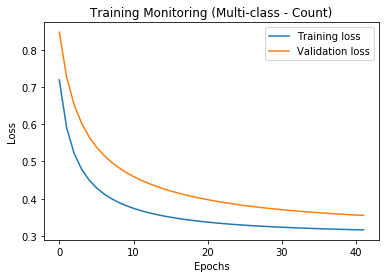

In [51]:
plt.plot(tr_loss_count, label='Training loss')
plt.plot(dev_loss_count, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training Monitoring (Multi-class - Count)')

plt.legend()

plt.show()

According to the plot **Training Monitoring (Multi-class - Count)**, 

1. The training loss decreases as epoch increases and eventually reaches a point of stability
2. The validation loss decreases as epoch increases and eventually reaches a point of stability
3. The validation loss is slightly higher than the training loss, i.e. the "generalisation gap" is small

The following techniques are implemented in the Stochastic Gradient Descent algorithm to avoid overfitting of the training data:

1. Early stopping
2. L2 regularisation

Hence, the model is **about right**.

Compute accuracy, precision, recall and F1-scores:

In [52]:
args = topic_test_labels, predict_class(topic_test_count, w_count)

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args, average='macro'))
print('Recall:', recall_score(*args, average='macro'))
print('F1-Score:', f1_score(*args, average='macro'))

Accuracy: 0.8688888888888889
Precision: 0.8698322446387462
Recall: 0.8688888888888888
F1-Score: 0.8682981036467744


Print the top-10 words for each class respectively.

In [53]:
top10_ids = (-w_count).argsort()[:, :10]

print(
    f'Top 10 Class 1 (World): {[vocab_id_to_word[id] for id in top10_ids[0]]} \n'
)
print(
    f'Top 10 Class 2 (Sports): {[vocab_id_to_word[id] for id in top10_ids[1]]} \n'
)
print(
    f'Top 10 Class 3 (Business): {[vocab_id_to_word[id] for id in top10_ids[2]]} \n'
)

Top 10 Class 1 (World): ['said', 'reuters', 'tuesday', 'ap', 'new', 'afp', 'wednesday', 'monday', 'over', 'president'] 

Top 10 Class 2 (Sports): ['ap', 'tuesday', 'reuters', 'athens', 'new', 'first', 'wednesday', 'olympic', 'team', 'said'] 

Top 10 Class 3 (Business): ['reuters', 'said', 'new', 'tuesday', 'company', 'oil', 'more', 'wednesday', 'over', 'about'] 



### Features Evaluation

The top 10 features obtained for each class using **count vectors** are reasonable. Most distinguishable features are:

1. World: president
2. Sports: athens, team, olympic
3. Business: company, oil

## Train and Evaluate Multi-class Logistic Regresstion with TF.IDF Vectors

In [54]:
w_tfidf, tr_loss_tfidf, dev_loss_tfidf = SGD(X_tr=topic_train_tfidf,
                                             Y_tr=topic_train_labels,
                                             X_dev=topic_dev_tfidf,
                                             Y_dev=topic_dev_labels,
                                             num_classes=3,
                                             lr=0.01525,
                                             alpha=0.00001,
                                             epochs=100)

Epoch: 0 | Training loss: 0.7216613877125208 | Validation loss: 0.8796561762011178
Epoch: 1 | Training loss: 0.5732100682261018 | Validation loss: 0.7641111956389048
Epoch: 2 | Training loss: 0.49377035863697055 | Validation loss: 0.6908691542400103
Epoch: 3 | Training loss: 0.44430555137295413 | Validation loss: 0.6395878142758307
Epoch: 4 | Training loss: 0.41057206955841585 | Validation loss: 0.6012886245734651
Epoch: 5 | Training loss: 0.38611747927519485 | Validation loss: 0.5713468972678108
Epoch: 6 | Training loss: 0.36760111800118694 | Validation loss: 0.547183982193356
Epoch: 7 | Training loss: 0.3530861584965032 | Validation loss: 0.5271780886441223
Epoch: 8 | Training loss: 0.34138522886689704 | Validation loss: 0.5102887736087635
Epoch: 9 | Training loss: 0.33180474145198685 | Validation loss: 0.4957813868840507
Epoch: 10 | Training loss: 0.3237883357829469 | Validation loss: 0.4831859213043515
Epoch: 11 | Training loss: 0.31701151756974283 | Validation loss: 0.472106063302

Plot training and validation process and explain if your model overfit, underfit or is about right:

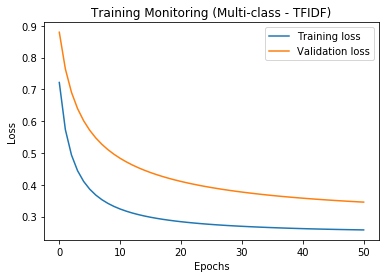

In [55]:
plt.plot(tr_loss_tfidf, label='Training loss')
plt.plot(dev_loss_tfidf, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title('Training Monitoring (Multi-class - TFIDF)')

plt.legend()

plt.show()

According to the plot **Training Monitoring (Multi-class - TFIDF)**, 

1. The training loss decreases as epoch increases and eventually reaches a point of stability
2. The validation loss decreases as epoch increases and eventually reaches a point of stability
3. The validation loss is slightly higher than the training loss, i.e. the "generalisation gap" is small 

The following techniques are implemented in the Stochastic Gradient Descent algorithm to avoid overfitting of the training data:

1. Early stopping
2. L2 regularisation

Hence, the model is **about right**.

Compute accuracy, precision, recall and F1-scores:

In [56]:
args = topic_test_labels, predict_class(topic_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(*args))
print('Precision:', precision_score(*args, average='macro'))
print('Recall:', recall_score(*args, average='macro'))
print('F1-Score:', f1_score(*args, average='macro'))

Accuracy: 0.8966666666666666
Precision: 0.8970314657551683
Recall: 0.8966666666666666
F1-Score: 0.8960678070376614


Print the top-10 words for each class respectively.

In [57]:
top10_ids = (-w_tfidf).argsort()[:, :10]

print(
    f'Top 10 Class 1 (World): {[vocab_id_to_word[id] for id in top10_ids[0]]} \n'
)
print(
    f'Top 10 Class 2 (Sports): {[vocab_id_to_word[id] for id in top10_ids[1]]} \n'
)
print(
    f'Top 10 Class 3 (Business): {[vocab_id_to_word[id] for id in top10_ids[2]]}'
)

Top 10 Class 1 (World): ['said', 'afp', 'ap', 'president', 'tuesday', 'monday', 'new', 'state', 'reuters', 'government'] 

Top 10 Class 2 (Sports): ['ap', 'athens', 'olympic', 'team', 'first', 'olympics', 'no', 'two', 'season', 'tuesday'] 

Top 10 Class 3 (Business): ['company', 'said', 'oil', 'new', 'reuters', 'more', 'business', 'million', 'prices', 'about']


### Features Evaluation

The top 10 features obtained for each class using **TF.IDF vectors** are reasonable. They are more relevant than the features obtained using **count vectors**. Most distinguishable features are:

1. World: president, state, government
2. Sports: athens, olympic, team, olympics, season
3. Business: company, oil. business, million, prices

## If we were to apply the classifier we've learned into a different domain such as laptop reviews or restaurant reviews, do you think these features would generalise well?

### Count Vectors and TF.IDF Vectors

Both count vectors model and TF.IDF vectors **would not generalise well**. The overall explanation is similar to the one in Binary models, with a few differences regarding the top features obtained.

1. The top features obtained by the Multi-Class models do not include any sentiment lexicons (e.g. good, bad, etc.).
2. Most of the top features apart of general-purpose words (e.g. said, about, etc.) are not applicable to laptop or movie reviews.

Therefore, Multi-Class models are less generalised and would have worse performance than the Binary models in the new domains. 

## Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How does the regularisation strength affect performance?

**Note:** Many similar explanations are already written in the hyperparameters discussion for **Binary Logistic Regression**, hence they are not repeated here.

Similarly, the initial lower and upper bound of learning rate is set to `0.0001` and `0.1` respectively. The initial lower and upper bound of regularisation strength is set to `0.00001` and `0.01` respectively.


### Count Vectors

#### Optimising Learning Rate

Initial parameters: `lr=0.0001, alpha=0.00001`

| Trial | Learning rate | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.0001        | 99     | 0.5631   | 0.6983    | 0.8343    | 0.8333 | 0.8325   |
| 1     | 0.0005        | 99     | 0.3693   | 0.4527    | 0.8600    | 0.8588 | 0.8580   |
| 2     | 0.001         | 82     | 0.3399   | 0.4035    | 0.8619    | 0.8611 | 0.8603   |
| 3     | 0.002         | 61     | 0.3247   | 0.3742    | 0.8650    | 0.8644 | 0.8637   |
| 4     | 0.003         | 50     | 0.3192   | 0.3623    | 0.8662    | 0.8655 | 0.8648   |
| 5     | 0.004         | 42     | 0.3167   | 0.3566    | 0.8698    | 0.8688 | 0.8682   |
| 6     | 0.005         | 38     | 0.3147   | 0.3514    | 0.8688    | 0.8677 | 0.8672   |
| 7     | 0.0045        | 40     | 0.3155   | 0.3536    | 0.8687    | 0.8677 | 0.8672   |
| 8     | 0.00425       | 41     | 0.3161   | 0.3550    | 0.8698    | 0.8688 | 0.8682   |

The optimal `lr` is found to be `0.00425`

#### Optimising Regularisation Strength

Initial parameters: `lr=0.00425, alpha=0.00001`

| Trial | Alpha    | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|----------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.00001  | 41     | 0.3161   | 0.3550    | 0.8698    | 0.8688 | 0.8682   |
| 1     | 0.00002  | 41     | 0.3160   | 0.3552    | 0.8698    | 0.8688 | 0.8682   |
| 2     | 0.000015 | 41     | 0.3160   | 0.3551    | 0.8698    | 0.8688 | 0.8682   |
| 3     | 0.0001   | 41     | 0.3154   | 0.3565    | 0.8698    | 0.8688 | 0.8682   |

No better `alpha` values have been found. The initial `alpha` is considered to be the optimal value.

**Conclusion:** Based on the trials above, it can be concluded that the optimal values are `lr=0.00425` and `alpha=0.00001`


### TF.IDF Vectors

#### Optimising Learning rate

Initial parameters: `lr=0.0001, alpha=0.00001`

| Trial | Learning rate | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.0001        | 99     | 0.8116   | 0.9398    | 0.8765    | 0.8766 | 0.8758   |
| 1     | 0.001         | 99     | 0.3748   | 0.5592    | 0.8882    | 0.8877 | 0.8869   |
| 2     | 0.003         | 99     | 0.2849   | 0.4173    | 0.8914    | 0.8911 | 0.8904   |
| 3     | 0.005         | 82     | 0.2716   | 0.3877    | 0.8937    | 0.8933 | 0.8927   |
| 4     | 0.007         | 72     | 0.2653   | 0.3715    | 0.8946    | 0.8944 | 0.8937   |
| 5     | 0.01          | 61     | 0.2609   | 0.3584    | 0.8945    | 0.8944 | 0.8937   |
| 6     | 0.011         | 59     | 0.2597   | 0.3546    | 0.8947    | 0.8944 | 0.8938   |
| 7     | 0.013         | 54     | 0.2587   | 0.3499    | 0.8958    | 0.8955 | 0.8949   |
| 8     | 0.015         | 51     | 0.2579   | 0.3453    | 0.8970    | 0.8966 | 0.8960   |
| 9     | 0.017         | 47     | 0.2578   | 0.3430    | 0.8938    | 0.8933 | 0.8927   |
| 10    | 0.016         | 49     | 0.2578   | 0.3440    | 0.8959    | 0.8955 | 0.8950   |
| 11    | 0.0155        | 50     | 0.2579   | 0.3446    | 0.8959    | 0.8955 | 0.8950   |
| 12    | 0.01525       | 50     | 0.2580   | 0.3454    | 0.8970    | 0.8966 | 0.8960   |

The optimal `lr` is found to be `0.01525`

#### Optimising Regularisation Strength

Initial parameters: `lr=0.0152, alpha=0.00001`

| Trial | Learning rate | Epochs | Tr. loss | Val. loss | Precision | Recall | F1-Score |
|-------|---------------|--------|----------|-----------|-----------|--------|----------|
| 0     | 0.00001       | 50     | 0.2580   | 0.3454    | 0.8970    | 0.8966 | 0.8960   |
| 1     | 0.00002       | 50     | 0.2578   | 0.3466    | 0.8970    | 0.8966 | 0.8960   |
| 2     | 0.000015      | 50     | 0.2579   | 0.3461    | 0.8970    | 0.8966 | 0.8960   |
| 3     | 0.0001        | 48     | 0.2572   | 0.3565    | 0.8970    | 0.8966 | 0.8960   |

No better `alpha` has been found. The initial `alpha` is considered to be the optimal value.

**Conclusion:** Based on the trials above, it can be concluded that the optimal values are `lr=0.01525` and `alpha=0.00001`

### Relationship Between Epochs and Learning Rate

According to the tables above, it has been shown that the higher the learning rate, the lower the epochs required to converge. This relationship is the same as the one in **Binary Logistic Regression**, hence the type of model does not affect the relationship between epochs and learning rate.

### Relationship Between Regularisation Strength and Model Performance

According to the tables above, it has been shown that the higher the regularisation strength, the lower the epochs required to converge. Moreover, the training and validation loss increase as the regularisation strength increases. This relationship is the same as the one in **Binary Logistic Regression**. 

However, no performance improvement is observed in both **Count Vectors** and **TF.IDF Vectors** of this multi-class model. 

Therefore, there is not enough evidence to state that the relationship between regularisation strength and model performance is consistent across different types of models.

## Full Results

|     LR    |      Precision     |       Recall       |      F1-Score      |
|:---------:|:------------------:|:------------------:|:------------------:|
| BOW-count | 0.8698296951326174 | 0.8688888888888888 |  0.868323408492766 |
| BOW-tfidf | 0.8970314657551683 | 0.8966666666666666 | 0.8960678070376614 |

# Justifications for Implementation Choices

## Lower Case for N-gram

Since the actual sentence structure and word order is not taken into account by the classifier, reducing all n-grams to lower case is a good strategy. It will allow instances of "*Best*" at the beginning of a sentence to be considered as "*best*". This will also help the model to identify features more accurately.

### Performance Improvement

Performance improvement is achieved in **Multi-class TFIDF Vectors**, as shown in the following table:

|     MLR TFIDF     |      Precision     |       Recall       |      F1-Score      |
|:-----------------:|:------------------:|:------------------:|:------------------:|
| Without lowercase | 0.8859205236286744 | 0.8855555555555555 | 0.8848282934618362 |
|   With lowercase  | 0.8970314657551683 | 0.8966666666666666 | 0.8960678070376614 |

### Top 10 Features Weight

Without lower case preprocessing:

- World: 'The', 'said', 'AFP', 'AP', 'Tuesday', 'Monday', 'President', 'Reuters', 'new', 'people'
- Sports: 'AP', 'The', 'Olympic', 'ATHENS', 'first', 'Olympics', 'team', 'two', 'Tuesday', 'season'
- Business: 'The', 'company', 'said', 'oil', 'Reuters', 'new', 'more', 'US', 'prices', 'business'

With lower case preprocessing:

- World: 'said', 'afp', 'ap', 'president', 'tuesday', 'monday', 'new', 'state', 'reuters', 'government'
- Sports: 'ap', 'athens', 'olympic', 'team', 'first', 'olympics', 'no', 'two', 'season', 'tuesday'
- Business: 'company', 'said', 'oil', 'new', 'reuters', 'more', 'business', 'million', 'prices', 'about'

The most noticeable difference is the increases in weight for more important terms in the following classes:

- World: 'president', 'state', 'government'
- Business: 'business', 'million'


## Log Normalisation Scheme for Term Frequency

Raw term frequency might not be ideal because: 

- It is known that a document with `tf = 10` occurrences for a term is more relevant than a document with `tf = 1` occurrence for that term
- However, this does not indicate that the document with `tf = 10` is 10 times more relevant than `tf = 1`

Hence, relevance does not increase proportionally with term frequency. Using a sublinear function to calculate term frequency will help to reduce the importance of the term that has a high frequency.

### Performance Improvement

| BLR TF Scheme |      Precision     | Recall |      F1-Score      |
|:-------------:|:------------------:|:------:|:------------------:|
| Raw frequency | 0.8507462686567164 |  0.855 | 0.8528678304239402 |
|   Log scaled  | 0.9025641025641026 |  0.88  | 0.8911392405063291 |

| MLR TF Scheme |      Precision     |       Recall       |      F1-Score      |
|:-------------:|:------------------:|:------------------:|:------------------:|
| Raw frequency | 0.8822875333701315 | 0.8822222222222221 | 0.8816177693062457 |
|   Log scaled  | 0.8970314657551683 | 0.8966666666666666 | 0.8960678070376614 |

### Top 10 Features Weight

The model is able to identify more relevant features using the log normalisation TF weighting scheme. 

#### Binary Logistic Regression TF.IDF

Raw frequency TF weighting scheme:

- Positive: 'great', 'fun', 'hilarious', 'terrific', 'overall', 'definitely', 'memorable', 'truman', 'pulp', 'perfectly'

- Negative: 'nbsp', 'bad', 'worst', 'boring', 'supposed', 'unfortunately', 'nothing', 'why', 'waste', 'script'

Log normalisation TF weighting scheme:

- Positive: 'hilarious', 'perfectly', 'terrific', 'great', 'memorable', 'overall', 'definitely', 'perfect', 'excellent', 'fun'

- Negative: 'bad', 'worst', 'boring', 'supposed', 'unfortunately', 'ridiculous', 'waste', 'script', 'awful', 'nothing'

#### Multi-Class Logistic Regression TF.IDF

Raw frequency TF weighting scheme:

- World: 'said', 'afp', 'ap', 'president', 'tuesday', 'new', 'monday', 'state', 'reuters', 'government' 

- Sports: 'ap', 'athens', 'olympic', 'team', 'quot', 'no', 'first', 'olympics', 'tuesday', 'one' 

- Business: 'company', 'oil', 'said', 'new', 'more', 'reuters', 'business', 'over', 'about', 'up'

Log normalisation TF weighting scheme:

- World: 'said', 'afp', 'ap', 'president', 'tuesday', 'monday', 'new', 'state', 'reuters', 'government'

- Sports: 'ap', 'athens', 'olympic', 'team', 'first', 'olympics', 'no', 'two', 'season', 'tuesday'

- Business: 'company', 'said', 'oil', 'new', 'reuters', 'more', 'business', 'million', 'prices', 'about'